# Projeto 2 de Ciência dos Dados - Predição de crimes em São Francisco

---
**Turma 2B**

**Integrantes:** Rafael Kahn, Hélio Zaia, Gabriel Parfan

---
## Introdução

Este projeto tem por objetivo fazer uma análise estatística dos crimes que ocorrem na cidade de São Francisco, tendo por base um DataFrame obtido do site kaggle; Com base nesses dados deu-se início à análise estatística buscando criar um algoritmo capaz de classificar um determinado crime com base no horário, distrito, bairro, dia da semana e localização geográfica. Já é de senso comum da população ao redor do mundo de que certas variáveis citadas anteriormente influenciam na possibilidade de algum tipo de crime acontecer, porém quanto essas variáveis realmente influenciam na possibilidade de um crime acontecer? Este trabalho pretende analisar essa influência e descobrir se é possível classificar que tipo de crime aconteceria dadas as circunstâncias mencionadas.

---
## Objetivo

O objetivo deste trabalho é responder a pergunta: Como pode-se classificar o crime que aconteceria dadas certas variáveis?

---
## Random Forest

Random Forest ou Floresta de Decisões Aleatórias é um método de classificação onde vários "galhos" de escolhas são criados a fim de formular uma decisão. Para gerar tal método, é necessário passar uma base de treinamento, em que é utilizada uma amostra de dados aleatória para o reconhecimento de padrões entre as variáveis ligadas ao dado. Após o treinamento, o processo é aplicado novamente, desta vez no teste, sendo possível ver se o método foi bem sucedido ou não.

---
## Preparo do dataset

In [1]:
#Bibliotecas
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn
from scipy.stats import norm, uniform, probplot
from sklearn import svm, datasets
from sklearn.utils.multiclass import unique_labels
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [2]:
#Definindo seed
RANDOM_SEED = 13
np.random.seed(RANDOM_SEED)

In [3]:
#Abrindo o dataset
data = pd.read_csv("Crimes_SF.csv")
data.head(10)

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
0,120058272,WEAPON LAWS,POSS OF PROHIBITED WEAPON,Friday,01/29/2016 12:00:00 AM,11:00,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.403404791479)",12005827212120
1,120058272,WEAPON LAWS,"FIREARM, LOADED, IN VEHICLE, POSSESSION OR USE",Friday,01/29/2016 12:00:00 AM,11:00,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.403404791479)",12005827212168
2,141059263,WARRANTS,WARRANT ARREST,Monday,04/25/2016 12:00:00 AM,14:59,BAYVIEW,"ARREST, BOOKED",KEITH ST / SHAFTER AV,-122.388856,37.729981,"(37.7299809672996, -122.388856204292)",14105926363010
3,160013662,NON-CRIMINAL,LOST PROPERTY,Tuesday,01/05/2016 12:00:00 AM,23:50,TENDERLOIN,NONE,JONES ST / OFARRELL ST,-122.412971,37.785788,"(37.7857883766888, -122.412970537591)",16001366271000
4,160002740,NON-CRIMINAL,LOST PROPERTY,Friday,01/01/2016 12:00:00 AM,00:30,MISSION,NONE,16TH ST / MISSION ST,-122.419672,37.765050,"(37.7650501214668, -122.419671780296)",16000274071000
5,160002869,ASSAULT,BATTERY,Friday,01/01/2016 12:00:00 AM,21:35,NORTHERN,NONE,1700 Block of BUSH ST,-122.426077,37.788019,"(37.788018555829, -122.426077177375)",16000286904134
6,160003130,OTHER OFFENSES,PAROLE VIOLATION,Saturday,01/02/2016 12:00:00 AM,00:04,SOUTHERN,"ARREST, BOOKED",MARY ST / HOWARD ST,-122.405721,37.780879,"(37.7808789360214, -122.405721454567)",16000313026150
7,160003259,NON-CRIMINAL,FIRE REPORT,Saturday,01/02/2016 12:00:00 AM,01:02,TENDERLOIN,NONE,200 Block of EDDY ST,-122.411778,37.783981,"(37.7839805592634, -122.411778295992)",16000325968000
8,160003970,WARRANTS,WARRANT ARREST,Saturday,01/02/2016 12:00:00 AM,12:21,SOUTHERN,"ARREST, BOOKED",4TH ST / BERRY ST,-122.393357,37.775788,"(37.7757876218293, -122.393357241451)",16000397063010
9,160003641,MISSING PERSON,FOUND PERSON,Friday,01/01/2016 12:00:00 AM,10:06,BAYVIEW,NONE,100 Block of CAMERON WY,-122.387182,37.720967,"(37.7209669615499, -122.387181635995)",16000364175000


In [4]:
#Conferindo as categoria de crime do dataset
data.Category.value_counts()

LARCENY/THEFT                  40409
OTHER OFFENSES                 19599
NON-CRIMINAL                   17866
ASSAULT                        13577
VANDALISM                       8589
VEHICLE THEFT                   6419
WARRANTS                        5914
BURGLARY                        5802
SUSPICIOUS OCC                  5782
MISSING PERSON                  4338
DRUG/NARCOTIC                   4243
ROBBERY                         3299
FRAUD                           2635
SECONDARY CODES                 1841
TRESPASS                        1812
WEAPON LAWS                     1658
SEX OFFENSES, FORCIBLE           940
STOLEN PROPERTY                  882
RECOVERED VEHICLE                736
DISORDERLY CONDUCT               658
PROSTITUTION                     641
FORGERY/COUNTERFEITING           619
DRUNKENNESS                      465
DRIVING UNDER THE INFLUENCE      378
ARSON                            286
KIDNAPPING                       257
EMBEZZLEMENT                     168
L

In [5]:
#Função para gerar crosstabs com a correlação entre valores escolhidos
def corrtab_data(data):
        k = [np.corrcoef(data.loc[data.index[a],:],range(0,len(data.columns)))[0,1] for a in range(len(data.index))]
        dic = dict(zip(data.index,k))
        return dic

In [6]:
#Limpeza Inicial
#Deixando apenas os crimes mais relevantes
data_f = data[(data['Category'] == 'LARCENY/THEFT') | (data['Category'] == 'ASSAULT') | (data['Category'] == 'OTHER OFFENSES') | (data['Category'] == 'VEHICLE THEFT')]
data_f.Category.value_counts()

LARCENY/THEFT     40409
OTHER OFFENSES    19599
ASSAULT           13577
VEHICLE THEFT      6419
Name: Category, dtype: int64

---
## Análise Exploratória

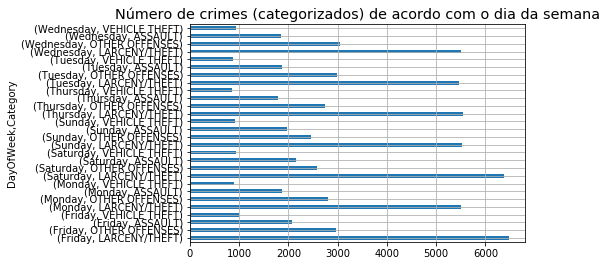

In [7]:
#Gráfico mostrando a quantidade de crimes por dia da semana
data_f.groupby('DayOfWeek').Category.value_counts().plot.barh()
plt.style.use("ggplot")
plt.title("Número de crimes (categorizados) de acordo com o dia da semana")
plt.grid(True)

In [8]:
#Tabela de relação entre os dias da semana e os tipos de crime
tabela_ds = pd.crosstab(data_f.Category, data_f.DayOfWeek, normalize = 'index')
tabela_ds

DayOfWeek,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
Category,,,,,,,
ASSAULT,0.153348,0.137365,0.158872,0.144804,0.131251,0.137954,0.136407
LARCENY/THEFT,0.160286,0.136183,0.157985,0.136875,0.137049,0.135440,0.136183
OTHER OFFENSES,0.151742,0.143171,0.131792,0.125261,0.140415,0.152457,0.155161
VEHICLE THEFT,0.155632,0.140676,0.145817,0.142546,0.133354,0.137249,0.144727


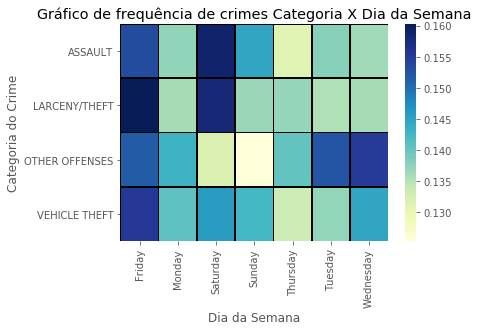

In [9]:
#Heatmap da tabela entre dias da semana e tipos de crime
seaborn.heatmap(tabela_ds, annot = False, fmt = 'd',linecolor="black",linewidth=.5,cmap='YlGnBu');
plt.title("Gráfico de frequência de crimes Categoria X Dia da Semana")
plt.xlabel("Dia da Semana")
plt.ylabel("Categoria do Crime")
plt.show()

- Como podemos observar pelo gráfico acima, o dia da semana não possui uma alta influência sobre os crimes que ocorrem na cidade de São Francisco, com exceção de sexta-feira que possui uma frequência de crimes mais elevada que nos outros dias.
---

In [10]:
#Criando e adicionando a coluna "Hour" ao dataframe
data_f["Hour"] = data_f.Time.str.slice(0,3) + "00"
data_f["Hour"].value_counts()
tabela_Category_Time = pd.crosstab(data_f.Category, data_f.Hour, normalize='index')
tabela_Category_Time

C:\Users\gabri\AppData\Roaming\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Hour,00:00,01:00,02:00,03:00,04:00,05:00,06:00,07:00,08:00,09:00,...,14:00,15:00,16:00,17:00,18:00,19:00,20:00,21:00,22:00,23:00
Category,,,,,,,,,,,,,,,,,,,,,
ASSAULT,0.048612,0.043088,0.039552,0.023348,0.015025,0.010533,0.017603,0.026074,0.033365,0.036385,...,0.046991,0.055903,0.055535,0.058039,0.051779,0.051337,0.054651,0.059070,0.048538,0.046476
LARCENY/THEFT,0.034423,0.025415,0.016110,0.009676,0.006682,0.007449,0.010913,0.015318,0.027073,0.032196,...,0.053948,0.054122,0.058626,0.068772,0.080477,0.080304,0.070009,0.056374,0.047588,0.042812
OTHER OFFENSES,0.067912,0.029338,0.023215,0.018981,0.013470,0.009439,0.012858,0.027042,0.042298,0.042298,...,0.049798,0.057605,0.059646,0.063371,0.056023,0.047758,0.040308,0.038471,0.046533,0.045564
VEHICLE THEFT,0.034585,0.026328,0.016669,0.011061,0.008880,0.010438,0.019629,0.025705,0.033339,0.034429,...,0.037701,0.040972,0.052656,0.073064,0.083969,0.073687,0.080542,0.072597,0.076803,0.062627


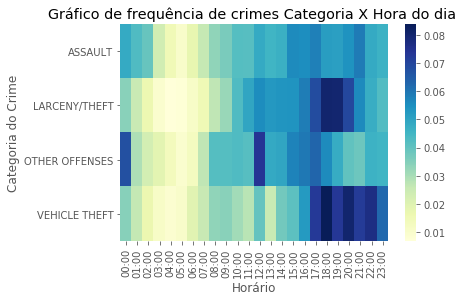

In [11]:
#Heatmap entre as horas do dia e o tipo de crime
seaborn.heatmap(tabela_Category_Time, annot = False, fmt = 'd', cmap='YlGnBu');
plt.title("Gráfico de frequência de crimes Categoria X Hora do dia ")
plt.xlabel("Horário")
plt.ylabel("Categoria do Crime")
plt.show()

In [12]:
#Obtendo a correlação entre as variáveis
Corr_Category_Hour = corrtab_data(tabela_Category_Time)
tabela_Corr_Category_Hour = pd.DataFrame([Corr_Category_Hour])
tabela_Corr_Category_Hour

,ASSAULT,LARCENY/THEFT,OTHER OFFENSES,VEHICLE THEFT
0,0.657891,0.785558,0.466086,0.862514


- O gráfico mostra a relação entre a frequência de crimes que acontecem em São Francisco em um dia qualquer e o horário em que eles acontecem. Nota-se a tendência dos crimes acontecerem em horários de fim de tarde e quase nunca de madrugada.
---

In [13]:
#Tabela entre bairros e tipo de crime
tabela_Category_District = pd.crosstab(data_f.Category, data_f.PdDistrict, normalize = 'index')
tabela_Category_District

PdDistrict,BAYVIEW,CENTRAL,INGLESIDE,MISSION,NORTHERN,PARK,RICHMOND,SOUTHERN,TARAVAL,TENDERLOIN
Category,,,,,,,,,,
ASSAULT,0.130736,0.087427,0.110923,0.155410,0.113133,0.038595,0.034838,0.173234,0.067614,0.088090
LARCENY/THEFT,0.058330,0.166799,0.044075,0.082187,0.178653,0.055039,0.077534,0.227752,0.064467,0.045164
OTHER OFFENSES,0.120057,0.088627,0.095260,0.152559,0.113220,0.055462,0.052146,0.170213,0.089341,0.063115
VEHICLE THEFT,0.168406,0.074934,0.142546,0.145194,0.115127,0.070416,0.080231,0.095498,0.083814,0.023835


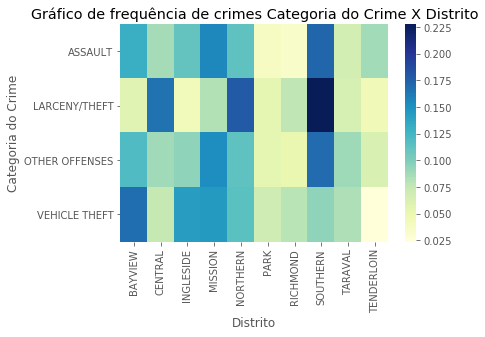

In [14]:
#Heatmap dos bairros com tipo de crime
seaborn.heatmap(tabela_Category_District, annot = False, fmt = 'd', cmap='YlGnBu');
plt.title("Gráfico de frequência de crimes Categoria do Crime X Distrito")
plt.xlabel("Distrito")
plt.ylabel("Categoria do Crime")
plt.show()

- O gráfico acima nos mostra quem existem bairros mais perigosos do que outros em São Francisco. É possível afirmar que bairros como Park, Richmond, Taraval e Tenderloin são bairros menos violentos e propícios à crimes.
---

In [15]:
#Tabela entre as horas dos crimes e os bairros
tabela_Hour_District = pd.crosstab(data_f.PdDistrict, data_f.Hour, normalize = 'index')
tabela_Hour_District

Hour,00:00,01:00,02:00,03:00,04:00,05:00,06:00,07:00,08:00,09:00,...,14:00,15:00,16:00,17:00,18:00,19:00,20:00,21:00,22:00,23:00
PdDistrict,,,,,,,,,,,,,,,,,,,,,
BAYVIEW,0.045467,0.024451,0.017843,0.016257,0.013349,0.010177,0.017314,0.024319,0.044277,0.037801,...,0.043087,0.043748,0.053132,0.061195,0.074015,0.070975,0.061856,0.059741,0.051811,0.048242
CENTRAL,0.039034,0.024051,0.022770,0.011434,0.006407,0.008280,0.009266,0.017053,0.027896,0.034993,...,0.058255,0.055495,0.060030,0.070478,0.076589,0.069492,0.066437,0.053031,0.048595,0.037654
INGLESIDE,0.054704,0.032625,0.022574,0.017960,0.011699,0.011040,0.013511,0.022244,0.035261,0.039545,...,0.043829,0.051244,0.053386,0.060636,0.063272,0.063602,0.062613,0.061130,0.057176,0.052727
MISSION,0.054100,0.043302,0.029082,0.021170,0.013365,0.008874,0.016893,0.022025,0.032503,0.034748,...,0.045761,0.050786,0.053352,0.063402,0.064364,0.056880,0.057415,0.051641,0.058056,0.054635
NORTHERN,0.041919,0.034150,0.022624,0.017075,0.010843,0.007513,0.013831,0.017929,0.032699,0.036114,...,0.047127,0.052335,0.055665,0.062495,0.071886,0.071288,0.065910,0.053103,0.049688,0.048579
PARK,0.029858,0.025659,0.018428,0.008631,0.011430,0.006765,0.015395,0.024259,0.033357,0.039655,...,0.050618,0.056916,0.065780,0.066247,0.061582,0.060182,0.059249,0.054817,0.048985,0.042454
RICHMOND,0.039860,0.018083,0.016138,0.005833,0.007389,0.006805,0.007972,0.015555,0.028388,0.030916,...,0.061637,0.064748,0.058526,0.069998,0.072720,0.070970,0.060859,0.052304,0.040832,0.031694
SOUTHERN,0.048439,0.028767,0.022575,0.011287,0.007998,0.007224,0.011868,0.021736,0.027864,0.033540,...,0.051600,0.056566,0.060823,0.071788,0.070949,0.070627,0.057340,0.050890,0.047794,0.047601
TARAVAL,0.046800,0.025120,0.015141,0.013765,0.009635,0.008087,0.011700,0.022368,0.036476,0.036992,...,0.055058,0.055231,0.053338,0.060392,0.065382,0.069683,0.065210,0.057811,0.051961,0.044219


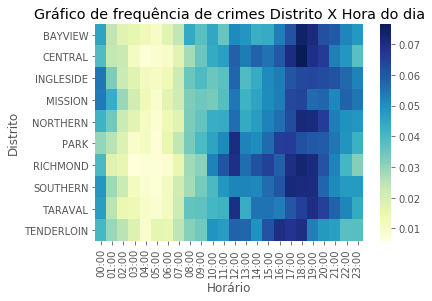

In [16]:
#Heatmap entre as horas dos crimes e os bairros
seaborn.heatmap(tabela_Hour_District, annot = False, fmt = 'd', cmap='YlGnBu');
plt.title("Gráfico de frequência de crimes Distrito X Hora do dia")
plt.xlabel("Horário")
plt.ylabel("Distrito")
plt.show()

In [17]:
#Obtendo a correlação entre variáveis
Corr_Hour_District = corrtab_data(tabela_Hour_District)

tabela_Corr_Hour_District = pd.DataFrame([Corr_Hour_District])
tabela_Corr_Hour_District

,BAYVIEW,CENTRAL,INGLESIDE,MISSION,NORTHERN,PARK,RICHMOND,SOUTHERN,TARAVAL,TENDERLOIN
0,0.787455,0.745778,0.757947,0.702664,0.767471,0.769941,0.678071,0.734609,0.755545,0.63442


- O gráfico acima reforça a observação de que os crimes geralmente acontecem nos horários vespertinos se prolongando até o começo da madrugada. Também mostra que a cidade possui uma faixa de crime em horários similares entre os seus diversos distritos.
---

In [18]:
#tabela entre dia da semana e hora dos crimes
tabela_DayOfWeek_Hour = pd.crosstab(data_f.DayOfWeek, data_f.Hour, normalize = 'index')
tabela_DayOfWeek_Hour

Hour,00:00,01:00,02:00,03:00,04:00,05:00,06:00,07:00,08:00,09:00,...,14:00,15:00,16:00,17:00,18:00,19:00,20:00,21:00,22:00,23:00
DayOfWeek,,,,,,,,,,,,,,,,,,,,,
Friday,0.043808,0.024896,0.018034,0.012448,0.008379,0.008538,0.014283,0.024098,0.028567,0.035429,...,0.046521,0.051309,0.057852,0.064874,0.069263,0.065911,0.062241,0.057932,0.053623,0.060246
Monday,0.041347,0.024375,0.019590,0.015167,0.010472,0.009750,0.016069,0.021035,0.037284,0.039271,...,0.050104,0.057597,0.060486,0.071138,0.072944,0.066444,0.062201,0.051007,0.043784,0.037916
Saturday,0.051741,0.041459,0.028690,0.018076,0.010365,0.009370,0.008624,0.016003,0.024876,0.028524,...,0.052156,0.052405,0.055473,0.056716,0.063847,0.057629,0.058955,0.058458,0.056136,0.061857
Sunday,0.056593,0.050520,0.037821,0.017208,0.010214,0.007546,0.011779,0.017116,0.025582,0.032760,...,0.049692,0.055581,0.056133,0.064875,0.061286,0.062207,0.055857,0.046931,0.050060,0.037821
Thursday,0.043466,0.020315,0.016105,0.012262,0.010981,0.008327,0.013635,0.020955,0.035597,0.040081,...,0.053807,0.053898,0.056918,0.065154,0.071925,0.072200,0.060853,0.054173,0.051428,0.041270
Tuesday,0.039144,0.023897,0.017566,0.013553,0.009897,0.008917,0.012840,0.023629,0.035845,0.035488,...,0.053500,0.051538,0.060366,0.067677,0.072581,0.073473,0.066251,0.053321,0.047347,0.037004
Wednesday,0.039205,0.020751,0.015629,0.012009,0.009448,0.008389,0.015541,0.022958,0.039735,0.037969,...,0.047770,0.057748,0.058013,0.072141,0.077704,0.071082,0.060309,0.053333,0.045563,0.040442


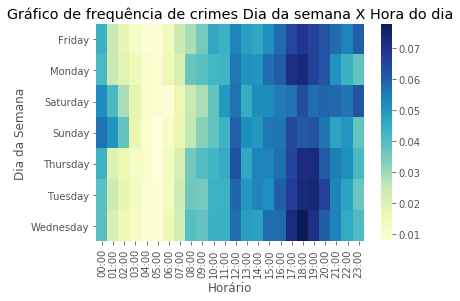

In [19]:
#Heatmap entre os dias da semana e a hora dos crimes
seaborn.heatmap(tabela_DayOfWeek_Hour, annot = False, fmt = 'd', cmap='YlGnBu');
plt.title("Gráfico de frequência de crimes Dia da semana X Hora do dia")
plt.xlabel("Horário")
plt.ylabel("Dia da Semana")
plt.show()

In [20]:
#Obtendo a correlação entre as variáveis
Corr_DayOfWeek_Hour = corrtab_data(tabela_DayOfWeek_Hour)

tabela_Corr_DayOfWeek_Hour = pd.DataFrame([Corr_DayOfWeek_Hour])
tabela_Corr_DayOfWeek_Hour

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,0.836512,0.731121,0.734373,0.538155,0.765946,0.755492,0.757657


- Observa-se a partir do gráfico acima que o horário em que os crimes são cometidos não dependem do dia, apesar de nos fins de semana os crimes se estenderem um pouco mais até antes de amanhecer.
---

In [21]:
#Tabela entre dia das semanas e bairros
tabela_DayOfWeek_District =  pd.crosstab(data_f.DayOfWeek, data_f.PdDistrict, normalize = 'index')
tabela_DayOfWeek_District 

PdDistrict,BAYVIEW,CENTRAL,INGLESIDE,MISSION,NORTHERN,PARK,RICHMOND,SOUTHERN,TARAVAL,TENDERLOIN
DayOfWeek,,,,,,,,,,
Friday,0.092802,0.130705,0.077162,0.109560,0.147782,0.053862,0.067986,0.197095,0.070061,0.052984
Monday,0.097409,0.128916,0.077999,0.114291,0.145888,0.055701,0.066083,0.186513,0.071770,0.055430
Saturday,0.085240,0.138557,0.071061,0.113765,0.153483,0.051575,0.061028,0.207463,0.065174,0.052653
Sunday,0.091846,0.128658,0.071047,0.123597,0.149733,0.050525,0.060464,0.198785,0.068839,0.056507
Thursday,0.103679,0.117039,0.074671,0.117862,0.143393,0.050970,0.067990,0.195827,0.077965,0.050604
Tuesday,0.095140,0.122960,0.080963,0.123406,0.142042,0.056442,0.060544,0.180562,0.078734,0.059206
Wednesday,0.096954,0.119382,0.078146,0.117174,0.141898,0.055982,0.065695,0.189051,0.076821,0.058896


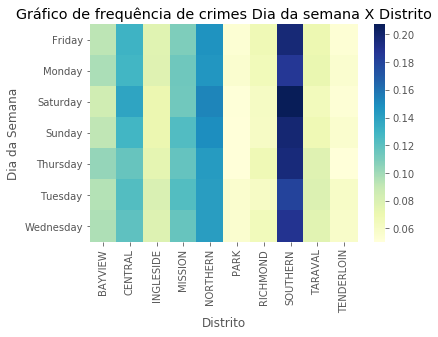

In [22]:
#Heatmap entre os dias da semana e os bairros
seaborn.heatmap(tabela_DayOfWeek_District, annot = False, fmt = 'd', cmap='YlGnBu');
plt.title("Gráfico de frequência de crimes Dia da semana X Distrito")
plt.xlabel("Distrito")
plt.ylabel("Dia da Semana")
plt.show()

- Este último HeatMap demonstra que existe uma relação entre a taxa de criminalidade e os distritos em que eles acontecem.

---
## Classificador Random Forest

In [23]:
#Retirando variáveis não utilizadas no classificador
data_f = data_f.drop(['Time','Date','Location','IncidntNum','Descript','Resolution'], 1).dropna()

In [24]:
#Obtendo frequência relativa das categorias
data_f.Category.value_counts(True)

LARCENY/THEFT     0.505081
OTHER OFFENSES    0.244978
ASSAULT           0.169706
VEHICLE THEFT     0.080234
Name: Category, dtype: float64

In [25]:
#Utilizando os métodos LabelEncoder() e OneHotEncoder() para manipular as variáveis categóricas
categorical_feature_mask = data_f.dtypes==object
categorical_cols = data_f.columns[categorical_feature_mask].tolist()
le = LabelEncoder()
data_f[categorical_cols] = data_f[categorical_cols].apply(lambda col: le.fit_transform(col))
categorical_features = categorical_feature_mask
ohe = OneHotEncoder(categorical_features, sparse=False)

In [26]:
#Visualizando dataset
data_f.head()

,Category,DayOfWeek,PdDistrict,Address,X,Y,PdId,Hour
5,0,0,4,3145,-122.426077,37.788019,16000286904134,21
6,2,2,7,11811,-122.405721,37.780879,16000313026150,0
10,1,0,8,2044,-122.477377,37.764478,16008686306240,22
12,2,1,0,3941,-122.376758,37.735697,16007301427170,23
13,0,4,2,13164,-122.432326,37.729271,14077677704011,7


In [27]:
#Variáveis a serem analisadas
x = data_f[['DayOfWeek', 'PdDistrict', 'Address', 'X', 'Y', 'PdId', 'Hour']]
y = data_f['Category']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=152)

In [28]:
#Verificando a acurácia do classificador
model = RandomForestClassifier(n_estimators=100)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print('Acurácia: {:.3f} %'.format(accuracy_score(y_test, y_pred)*100))

Acurácia: 63.193 %


In [29]:
#plotando uma matriz de confusão
matriz = pd.crosstab(y_test, y_pred, normalize = 'index')
matriz

col_0,0,1,2,3
Category,,,,
0,0.412645,0.246863,0.313948,0.026544
1,0.062210,0.804765,0.115900,0.017124
2,0.156672,0.246711,0.563984,0.032633
3,0.129436,0.290710,0.356472,0.223382


- 0 representa a categoria de LARCENY/THEFT.<br>
- 1 representa a categoria de ASSAULT<br>
- 2 representa a categoria de OTHER OFFENSES<br>
- 3 representa a categoria de VEHICLE THEFT.

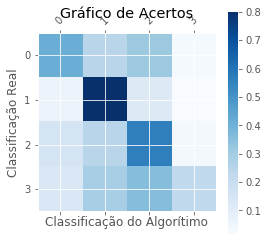

In [30]:
#Criando o gráfico da matriz de confusão
def plot_confusion_matrix(df_confusion, cmap=plt.cm.Blues):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)

#Plotando o gráfico
plot_confusion_matrix(matriz)
plt.title("Gráfico de Acertos")
plt.xlabel("Classificação do Algorítimo")
plt.ylabel("Classificação Real");

- Como é possível observar na matriz de confusão acima, o classificador atingiu resultados medianos, nota-se isso ao reparar que os resultados Verdadeiro-Verdadeiro foram satisfatórios para ASSAULT (1, 1), porém não foi bom para o VEHICLE THEFT (3, 3). Além disso, os extremos superior direito e inferior esquerdo estão satisfatórios por apresentarem baixa intensidade, logo, os Verdadeiros-Falso não afetaram tanto. Os resultados para Falso-Verdadeiros também foram bom-medianos, estando dividos entre intensidades de azul fracas e médias.

---
## Conclusão e possíveis iterações

Após analisar o projeto, podemos afirmar que por não existir nenhum erro de codificação no trabalho, a falta de uma maior precisão ( mesmo que a precisão obtida seja razoavelmente boa, em 63%) é devido ao próprio classificador.<br>
Uma das maneiras de melhorar essa precisão do classificador, seria adicionar mais variáveis expressivas para a determinação e classificação dos crimes, como por exemplo o sexo das pessoas que sofreram o crime, visto que variáveis como essa devem ter uma boa influência no número de crimes sofridos.<br>
Outra maneira de melhorarmos a acurácia do nosso classificador, seria a adição de uma base de dados mais extensa e mais bem distribuída, visto que a base de dados utilizada tinha muito mais casos de roubo do que das demais categorias, fator este que influencia na precisão do classificador.<br>
Portanto, podemos concluir que o classificador fez um bom trabalho em classificar os tipos de crime baseado nas variáveis apresentadas no dataset, mesmo que ainda seja necessário melhorar um pouco sua precisão e sua base de dados.

## Fontes:

https://towardsdatascience.com/encoding-categorical-features-21a2651a065c<br>
https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn<br>
https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py<br>
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html